# Introduction

## Data

I selected CVS Health Corp (Ticker: CVS) to use MACD strategy to do analysis. I downloaded 5-year daily Adj Close data from 4/21/2011 to 4/20/2015 on $\href{https://finance.yahoo.com/quote/CVS/history?period1=1303344000&period2=1429488000&interval=1d&filter=history&frequency=1d}{\text{Yahoo Finance}}$.

## MACD Strategy

Moving Average Convergence/Divergence (MACD) is a momentum indicator widely popular among practitioners. In MACD, momentum is calculated as the difference between a fast EMA and a slow EMA. An exponential moving average (EMA) is a type of moving average (MA) that places a greater weight and significance on the most recent data points:  
$$
\begin{aligned} 
ema(P_t,\beta) = \beta*P_t+(1-\beta)*ema(P_{t-1},\beta)  \\
\beta = \frac{2}{n+1}, \beta<1  \\
\text{starting from short moving average (sma)}  \\
\end{aligned} 
$$
The typical fast and slow periods are 12 and 26 days, respectively. The difference
$$
MACD_t = ema(P_t,12)-ema(P_t,26)
$$
is called the $\textit{MACD line}$. Its exponential smoothing is called the $\textit{signal line}$:
$$
\textit{signal line}=ema(MACD_t,9)
$$
Because the signal line evolves slower than the MACD line, their crossovers can be interpreted as trading signals. Namely, buying opportunity appears when the MACD line crosses from below to above the signal line. On the contrary, crossing the signal line by the MACD line from above can be seen as a selling signal.  
  

# Bootstrap

A universal method to the data snooping bias is data resampling. Bootstrap is the most popular resampling procedure, which implies creating multiple data sets by randomly drawing the elements of a given sample with replacement.  
A more wise approach implies estimating a mathematical models that fits the given sample and bootstrapping the model's residuals. Typical models used for stock prices are the random walk with drift, the AR models and the GARCH models.  
In my project, I used the AR(1) model. The step of Bootstrap is stated below:  
1. Calculate the logarithmic returns of stock price, $r_t=log(P_t)-log(P_{t-1})$ 
2. Estimate with OLS (Ordinary Least Squares) $\alpha$ and $\beta$ for  
$$
\begin{aligned}
r_t &=\alpha+\beta r_{t-1}+\epsilon_t  \\
\epsilon_t &= IID(0,\sigma^2)  \\
\sigma^2 &= Var(\epsilon_t)
\end{aligned}
$$  
The result of OLS is shown below, we can conclude that both $\alpha=0.0012$ and $\beta=-0.0598$ are significant because p-value is less than 0.1.
![](OLS.png)
3. Calculate residuals $e_t=r_t-\alpha-\beta r_{t-1}$
4. Generate new sample with bootstrapped residuals $\check{r}_t=\alpha+\beta\check{r}_{t-1}+\check{e}_t$, where $\check{e}_t$ is randomly selected from $e_t$ every time.
5. Compile new price sample $\check{P}_t=\check{P}_{t-1}\exp(\check{r}_t), \check{P}_0=P_0.$ The new price sample is used to test the robustness of MACD strategy.
6. Repeat step 4 and 5 100 times.

# Conclusion

## Result

// ----------------------------------------------------ADD RESULT TABLE
1. According to the performance table above, during the 5 years, under MACD strategy, it has 33 round-trip rates using the actual data. Moreover, the total return in 5 years is 79.05%. The max drawdown is 11.56%. 
2. As for the back-testing using bootstrap, the average total return is 62.50 which is close to the empirical data though there are some returns below it. The average maximum drawdown 15.83% . Also, the number percentage of winning trades is 45.00%, which demonstrates that most returns of round-trip trades are negative. 
3. In a nutshell, MACS strategy is a satisfied strategy which balances return and volatility. Though it is a litter risky, it is also profitable. To be honest, we may need more tests to ensure the solidity of MACD strategy, for example, taking the transaction fee into consideration.
4. To check if the 100 total return list is a normal distribution, we use Kolmogorov-Smirnov test of scipy.stats.kstest function, which returns the D-value and the p-value. According to the result below, we can conclude that the return serise is a normal distribution.
![](KS.png)
5. To check if mean total return differs from zero and the average return, we use Student’s T-Test of stats.ttest_1samp, which returns t-statistic and the p-value. As for the test comparing to 0, p-value is 14.72006344 which is much less than 0.05, so it differs from 0 significantly. AS for the test to check if the return list equals to the average return, we also use T-Test. However, the p-value is 0.9651512 which is larger than 0.05. Hence, we cannot conclude that the return of MACD strategy equals to 62.5% siginificantly.
![](T test.png)


## Improvement

# Source Code

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats
import random
random.seed(0) 
import math
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
df = pd.read_csv('CVS.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2011-04-21,36.240002,36.340000,36.130001,36.209999,30.202391,4603300
1,2011-04-25,36.049999,36.220001,35.930000,36.020000,30.043913,3879700
2,2011-04-26,36.139999,36.630001,36.080002,36.090000,30.102303,9300000
3,2011-04-27,36.160000,36.480000,36.049999,36.369999,30.335857,7989700
4,2011-04-28,36.250000,36.320000,36.020000,36.250000,30.235748,8127800


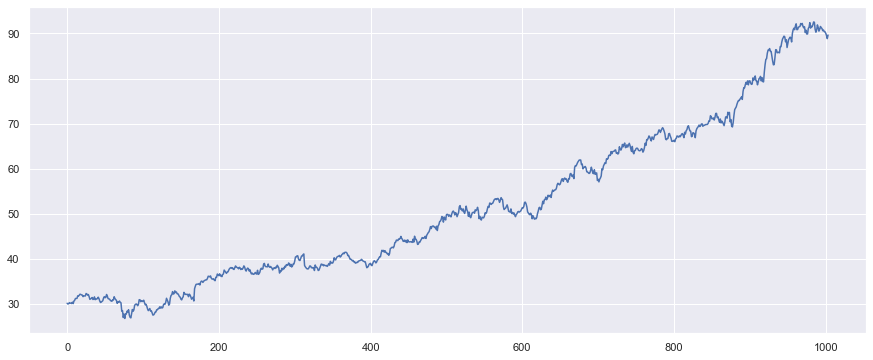

In [3]:
plt.figure(figsize=(15,6))
plt.plot(df['Adj Close'])
plt.show()

In [4]:
def getSignal(df, priceName):
    df['EMA_12day'] = df[[priceName]].ewm(span=12, min_periods=12, adjust=False).mean()
    df['EMA_26day'] = df[[priceName]].ewm(span=26, min_periods=26, adjust=False).mean()
    df['MACD'] = df['EMA_12day'] - df['EMA_26day']
    df['Signal_line'] = df[['MACD']].ewm(span=9, min_periods=9, adjust=False).mean()
    df['Signal'] = np.where((df['MACD']-df['Signal_line'])>0, 'Buy', 'Sell')
    return df

In [5]:
def Strategy(df, priceName):
    df['Action'] = '-'
    num_trades = 0
    num_pos_trades = 0 
    # return_list is used to calculate the return of each round
    return_list = []
    # close is uesd to save the adj close during trading period
    close = pd.Series(data=None)
    # Suppose we can't buy sell
    # Find the first buy signal
    begin = df[df['Signal']=='Buy'].index.tolist()[0]

    for i in range(begin, len(df)):
        if df['Signal'].iloc[i]=='Buy' and df['Signal'].iloc[i-1]=='Sell':
            df.loc[i, 'Action']='Buy'
            mark = i
        if df['Signal'].iloc[i]=='Sell' and df['Signal'].iloc[i-1]=='Buy':
            df['Action'].iloc[i]='Sell'
            close = pd.Series.append(close, df[priceName].iloc[mark:i+1], 
                                     ignore_index=True)
            num_trades += 1
            r = df.loc[i, priceName] / df.loc[mark, priceName] - 1
            return_list.append(r)
            if r > 0:
                num_pos_trades += 1

    return_list = pd.DataFrame(return_list, columns={'return'})
    return df, num_trades, num_pos_trades, return_list, close

In [6]:
def calCumReturn(return_list):
    cum_return = (1+return_list).cumprod()
    total_return_pct = 100*(cum_return.iloc[-1] - 1)
    total_return_pct = total_return_pct[0].round(2)
    return total_return_pct

In [7]:
def calWinTrades(num_pos_trades, num_trades):
    win_trades = num_pos_trades/num_trades
    win_trades_pct = 100*win_trades
    return win_trades_pct

In [8]:
def calDrawDown(df, close):
    df['drawdown'] = pd.DataFrame(close)/pd.DataFrame(close).cummax()-1
    max_drawdown = - df['drawdown'].min()
    max_drawdown_pct = max_drawdown*100
    return max_drawdown_pct

## Bootstrap

In [9]:
# Bootstrap using AR(1)
# rt is the log retruns = log(Pt)-log(Pt-1)
rt = np.log(df['Adj Close']).diff()
X = rt[1:-1]
Y = rt[2:]
X = sm.add_constant(X)
model = sm.OLS(np.array(Y), np.array(X))
results = model.fit()
alpha = results.params[0]
beta = results.params[1]
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     3.591
Date:                Wed, 13 May 2020   Prob (F-statistic):             0.0584
Time:                        12:54:22   Log-Likelihood:                 3074.6
No. Observations:                1002   AIC:                            -6145.
Df Residuals:                    1000   BIC:                            -6135.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.000      3.233      0.0

In [10]:
# Calculate residuals
rt_est = results.predict(sm.add_constant(rt[1:]))
rt_est = rt_est.reset_index(drop=True)
# In textbook, the standardized residuals = (rt - alpha - beta*rtX)/std(residual)
# rt_actual = rt.reset_index(drop=True)
rt_actual = rt[1:].reset_index(drop=True)
# residuals = (rt_actual - rt_est)/(rt_actual - rt_est).std()
residuals = (rt_actual - rt_est)

In [11]:
def createNewSample(alpha,beta , rt_actual, residuals, df):
    r_sample = [rt_actual[0]]    
    new_price = []
    for i in range(0, len(residuals)):
        index = math.floor(random.random()*len(residuals))
        random_residuals = residuals[index]
        random_return = alpha + beta *r_sample[i-1] + random_residuals
        r_sample.append(random_return)
    new_price.append(df['Adj Close'].iloc[0])
    for i in range(1, len(residuals)+1):
        new_price.append(new_price[i-1] * np.exp(r_sample[i-1]))
    return pd.DataFrame(data=new_price, columns={'Price_sample'})

In [12]:
# Calculate using empirical data
data = getSignal(df, 'Adj Close')
data, num_trades, num_pos_trades, return_list, close = Strategy(data, 'Adj Close')
total_return_pct = calCumReturn(return_list)
win_trades_pct = calWinTrades(num_pos_trades, num_trades)
max_drawdown_pct = calDrawDown(data, close)
result = pd.DataFrame(data=[[num_trades, total_return_pct, win_trades_pct, max_drawdown_pct]], index= ['Empirical'])

# 100 times bootstrap
total_return_list = [total_return_pct]
for i in range(100):
    Price_sample = createNewSample(alpha,beta, rt_actual, residuals, df)
    data = getSignal(Price_sample, 'Price_sample')
    data, num_trades, num_pos_trades, return_list, close = Strategy(Price_sample, 'Price_sample')
    total_return_pct = calCumReturn(return_list)
    total_return_list.append(total_return_pct)
    win_trades_pct = calWinTrades(num_pos_trades, num_trades)
    max_drawdown_pct = calDrawDown(data, close)

    Bresult = pd.DataFrame(data=[[num_trades, total_return_pct, win_trades_pct, max_drawdown_pct]], index=['B'+str(i+1)])
    result = pd.concat([result, Bresult], axis=0)

/Users/carol/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  
/Users/carol/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [13]:
result.loc['Average'] = result.mean()
result = result.rename(columns={0: '# of round-trip trades', 1: 'Total return, %', 2: 'Winning trades, %', 3:'Max drawdown, %'})
result = result.round(decimals=2)
pd.set_option('display.max_rows', None)
result

,# of round-trip trades,"Total return, %","Winning trades, %","Max drawdown, %"
Empirical,33.0,79.05,63.64,11.56
B1,41.0,22.48,41.46,12.56
B2,41.0,44.46,31.71,20.34
B3,44.0,46.94,45.45,13.26
B4,36.0,58.53,50.00,17.98
B5,39.0,74.95,38.46,9.12
B6,38.0,77.95,42.11,12.56
B7,40.0,109.38,57.50,12.52
B8,42.0,5.07,30.95,36.15
B9,33.0,107.19,48.48,20.68


# P/L histogram

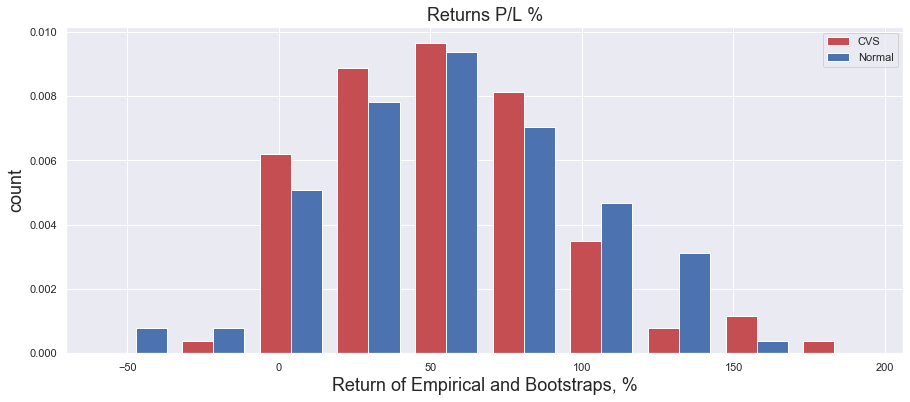

In [14]:
total_return_list = pd.DataFrame(total_return_list, columns={'total return'})

total_return_list = total_return_list.values
m = total_return_list.mean()
std = total_return_list.std()
normal_dist = np.random.normal(m, std, 100)
plt.figure(figsize=(15,6))
plt.title('Returns P/L %', fontsize=18)
plt.xlabel('Return of Empirical and Bootstraps, %', fontsize=18)
plt.ylabel('count', fontsize=18)
plt.hist([total_return_list, normal_dist], density = True, label =['CVS','Normal'], color=['r', 'b'])
plt.legend()

## KS Test

In [15]:
stats.kstest(total_return_list, 'norm')

KstestResult(statistic=1.0, pvalue=0.0)

## Student’s T-Test

In [16]:
stats.ttest_1samp(total_return_list, 0)

Ttest_1sampResult(statistic=array([14.16907109]), pvalue=array([1.18943035e-25]))

In [17]:
stats.ttest_1samp(total_return_list[1:-1], 62.5)

Ttest_1sampResult(statistic=array([-1.4407649]), pvalue=array([0.15283855]))